# <span style="color:green"> Run on python 3.6</span>

# Explanations:

Авторы используют multi output GPR, настраивая гиперпараметры $\sigma_{cov}$ и $\sigma_{err}$ (можно однозначно их выразить через гиперпараметры из того же sklearn: $l$ и $\sigma$)

GPR - непараметрический метод, суть в том, что мы делаем предположение о виде матрицы корреляции признаков для известных данных. (но можно добавлять некоторые параметры в ядро и их градиентными методами "обучать", потому что все что мы делаем - перемножаем матрицы и используем элементарные функции)

---

Моделирование в хотя бы немного более сложном случае буду писать на Julia

---

Гиперпараметры:

1)k: Количество элементов в массивах r_cut и p для каждого атома

2)$r_{cut}(i)_j$, i=1..k, j=1..N: векторы r_cut для j атома тоже параметр

3)$p_(i)_j$, i=1..k, j=1..N: векторы p для j атома тоже параметр

4)N_neighbours for summation for IVs

В GPyTorch есть имплементация многоразмерного регрессора: https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/index.html#multi-output-vector-valued-functions

---

- **Зачем предсказывать именно K-мерный вектор силы:** 
    - В системе из 3+ частиц гантелька из двух частиц может вращаться, тогда матрица признаков не изменяется у частиц из этой гантельки, а 3Д сила изменяется, но любое отображение может выдавать только 1 значение для 1 аргумента, то есть мы банально сможем выдавать только одну 3Д силу в таком случае,
    однако если мы предсказываем К-мерный вектор, то он все равно будет только 1 выдаваться для частицы из этой вращающейся гантельки, но матрица А при этом будет разной в каждом состоянии и сможем получать разные 3Д векторы силы 

---

Пока что все размерности предполагаются в системе LJ, потому что пока пытаюсь это зафитить

В данный момент при вычислении псевдообратной матрицы очень большая ошибка получается

In [91]:
import random
import os
import time

from numba import jit, njit, vectorize
import numpy as np
import scipy
from numpy.linalg import norm as norm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [92]:
def set_seed(seed=42):
    '''
    
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.

    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(25)

---

# Hyperparameters:

In [93]:
class CFG:
    '''

    All hyperparameters are here

    '''

    N = 2     # число атомов
    K = 5     # можно называть это разрешением...чем число больше, тем больше размеры матрицы для атомов, фактически это число элементов в наборах p и r_cut

    L = L = 2 * N ** (1 / 3) # размер одной клетки при моделировании

    r_cut = np.random.uniform(low=5, high=10, size=K).copy()
    p = np.random.uniform(low=1, high=3, size=K).copy()
    N_neig= N - 1 if N != 2 else 1

    # train_bs = 8
    # val_bs = 16
    batch_size = 64

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    f_threshold = 10    # Если сила по какой-то координате превышает это значение, то строчка исключается, совсем маленьких по модулю сил быть не должно, если что при генерации просто r_cut поменьше надо делать
    coord_threshold = 2 * L     # Если вдруг очень большие расстояния, то надо выкидывать
    #
    output_size = K     # Размерность аутпута модели

In [94]:
f'p: {CFG.p}, r_cut: {CFG.r_cut}'

'p: [1.23475109 2.36993749 1.87522212 2.11245865 1.73416064], r_cut: [9.35062068 7.91138464 6.3941947  5.92955616 7.05550064]'

---

Имеется два .csv файла:

1)
| Id(time) | 1_x | 1_y | 1_z | ... | N_z |
|------|-----|-----|-----|-----|-----|
|      |     |     |     |     |     |
|      |     |     |     |     |     |
2)
| Id(time) | f_1_x | f_1_y | f_1_z | ... | f_N_z |
|------|-----|-----|-----|-----|-----|
|      |     |     |     |     |     |
|      |     |     |     |     |     |

Одна строчка отсюда превращается в N матриц (на каждый атом) с N векторами сил

В идеале сделать БДху из двух сущностей: сила и координата, где полями будут их проекции

In [95]:
def create_df_with_coords(coords_file_path = None, forces_file_path = None):
    '''
    just makes df from .csvs with coords and forces
    '''
    coords = pd.read_csv(coords_file_path)

    forces = pd.read_csv(forces_file_path)

    if CFG.N != int(coords.columns[-1][:-1]) + 1:
        raise Exception('Constant N is not equal to amount of particles in .csv')

    return pd.merge(left=coords, right=forces, on='t').drop('t', axis='columns')

12 индекс - 1 отн 2

$$
\vec{r_1} = \vec{r_2} + \vec{r}_{12}
$$

$$
\vec{r}_{12} = \vec{r_1} - \vec{r}_{2}
$$

In [96]:
def _get_relative_positions(row, atom_number):
    '''
    This function processes one row of csv into something that we can work with

    Returns np.array matrix that consists of relative positions vectors for passed atom_number to every other atom
    and then we can chose only closest N_neighbours in the next functions
    
    row: df.iloc[row] - typeof(row): pd.Series
    
    returns: Rel_matrix, f_vec
    '''

    s_coord = pd.Series(dtype=float)
    other_atom_numbers = [i for i in range(CFG.N) if i != atom_number]

    for other_numb in other_atom_numbers:
        index = str(atom_number) + str(other_numb)
        for axis in ['x', 'y', 'z']:
            s_coord[index + axis] = row[str(atom_number) + axis] - row[str(other_numb) + axis]

    # we need force vector only for atom_number:
    force_vec = []
    for f_axis in ['f_x', 'f_y', 'f_z']:
        force_vec.append(row[str(atom_number) + f_axis])

    Rel_matrix = []
    cur_vector = []

    for (i, elem) in enumerate(s_coord.values):
        if i % 3 == 0 and i != 0:
            Rel_matrix.append(cur_vector)
            cur_vector = []

        cur_vector.append(elem)
    Rel_matrix.append(cur_vector)

    return np.array(Rel_matrix), np.array(force_vec)

In [97]:
from sklearn.preprocessing import normalize

In [98]:
@njit(fastmath=True)
def make_one_vec_transformed(vec, vec_norm, r_cut_i, p_i):
    '''
    vec: np.array - normalized vector
    norm: its norm
    r_cut_i: i-th component of
    '''
    return vec * np.exp(
        -np.power((vec_norm / r_cut_i), p_i)
        )

make_matrix_transformed = np.vectorize(make_one_vec_transformed)

def create_V_i(i, normalized_m, norms, r_cut=CFG.r_cut, p=CFG.p):
    '''
    normalized_m: matrix of relative distances, where rows - normalized vectors
    i: i-th component of r_cut and p, i in range 1..K (or in 0..K-1 in code)
    '''
    transf_vecs = make_matrix_transformed(normalized_m, norms[:, np.newaxis], r_cut[i], p[i])

    return np.sum(transf_vecs, axis=0)

# @njit(parallel=True)
def create_V(normalized_m, norms, K=CFG.K):
    '''
    creates V
    '''
    V = []
    for i in range(K):
        V.append(
            create_V_i(i, normalized_m, norms)
        )

    return np.stack(V)

In [99]:
# @njit(
#     # parallel=True,
#     # fastmath=True
#     )
def _calculate_matrix_for_atom(relative_distances, r_cut=CFG.r_cut, p=CFG.p, N_neig=CFG.N_neig, K=CFG.K):
    '''

    relative_distances: np.array matrix of relative distance vectors

    '''
    
    # Only closest N_neig are counting:
    indexlist = np.argsort(norm(relative_distances, axis=1))

    relative_distances = relative_distances[indexlist[len(relative_distances) - N_neig:]]

    norms = norm(relative_distances, axis=-1)

    normalized_rel_distances = relative_distances / norms[:, np.newaxis]

    V = create_V(normalized_rel_distances, norms)

    if np.inf in V / norm(V, axis=-1)[:, np.newaxis] or np.nan in V / norm(V, axis=-1)[:, np.newaxis]:
        print(f'V:\n {V}\n norms:\n {norm(V, axis=-1)[:, np.newaxis]}\n normed_V:\n {V / norm(V, axis=-1)[:, np.newaxis]}')
        print(f'ABOUT RELATIVE DISTANCES:\n rel_dists:\n {relative_distances}\n norms:\n{norms}\n normalized_rel_dists:\n {normalized_rel_distances}')

    A = V / norm(V, axis=-1)[:, np.newaxis]

    X = V @ A.T

    return X, A

In [100]:
def get_matrix_for_atom(row = None, atom_number = None, N_neig=CFG.N_neig):
    '''

    This function will create X matrix for passed atom with
    arrays of r_cut and p of length k

    It is a wrapper for _get_relative_positions and _calculate_matrix_for_atom, so I can speed up matrix calculations
    with numba for _calculate_matrix_for_atom

    atom_number: a number of atom that we are passing
    row: one row from df_with_coords, i.e. df.iloc[index_of_row]

    '''

    # creating row of relative coordinates for concrete atom:
    relative_distances, f_vec = _get_relative_positions(row=row, atom_number=atom_number)
    X, A = _calculate_matrix_for_atom(relative_distances=relative_distances, N_neig=N_neig)
    
    return X, f_vec, A

# %timeit get_matrix_for_atom(row=df.iloc[0], atom_number=1)

In [101]:
from tqdm import tqdm
import gc
import torchvision.transforms as transforms

**У нас будет train и val выборки, все-таки выборку, для который известен таргет принято называть validation, на которой мы качество оцениваем, а test это все-таки выборка, для который неизвестны таргеты**

In [102]:
def clean_df(df: pd.DataFrame, f_threshold = CFG.f_threshold, coord_threshold=CFG.coord_threshold):
    '''

    Убирает строчки с аномально большими силами из df

    '''

    indexes_for_deletion = set()

    for numb in range(CFG.N):
        for coord in ['f_x', 'f_y', 'f_z']:

            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) > f_threshold].index)
            )

        for coord in ['x', 'y', 'z']:
            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) > coord_threshold].index)
            )

    return df.drop(list(indexes_for_deletion))

In [103]:
@njit
def get_pinv(A):
    '''

    returns pseudoinverse matrix for input

    '''
    return np.linalg.pinv(A)

def get_projections(vec_to_project, mat_of_directions):
    '''

    returns projection of vec_to_project on every vector from mat_of_directions

    '''
    return (mat_of_directions @ vec_to_project) / norm(mat_of_directions, axis=-1)

def create_tensor_dataset(
    coords_file_path = 'coords.csv', forces_file_path = 'forces.csv', step=1, transform=transforms.ToTensor(), length=None,
    f_threshold=CFG.f_threshold,
    coord_threshold=CFG.coord_threshold,
    ):
    '''

    Примитивная версия датасета, просто все будет хранить в одном списке...

    Эта функция - wrapper на все выше написанные функции, она по переданным путям к .csv
    возвращает тензор из матриц для каждого атома в каждой строчке и тензор из векторов сил

    ИНогда есть смысл делать побольше шаг между соседними строчками, поскольку если есть почти одинаковые матрицы, то
    это по-сути линейная зависимость и модель тогда надо сильнее регулизировать

    transform: преобразование к X части датасета, в основном для нормализации нужно, хотя о нормализации надо еще подумать и будет ли тогда наше МНК через матрицу A+ работать

    step: через сколько строчек шагать при чтении csv в датасет, чтобы уж совсем одинаковых не было

    Возвращает: list of (X, k_dim_f, A_pinv, F_3D)

    '''

    dataset = []

    df = create_df_with_coords(coords_file_path=coords_file_path, forces_file_path=forces_file_path)
    if length:
        df = df.loc[range(length)]

    # Сюда будет вставлена чистка df от больших сил
    df = clean_df(df, f_threshold=f_threshold, coord_threshold=coord_threshold)

    row_indexes = [i for i in range(0, len(df.index), step)]

    for atom_number in range(CFG.N):
        for index in tqdm(row_indexes, desc=f'Progress for atom {atom_number}'):
            row = df.iloc[index]
            x, F_3D, A = get_matrix_for_atom(row=row, atom_number=atom_number)
            
            if transform:
                x = transform(x)
            else:
                x = torch.tensor(x)
            x = x.to(torch.float)

            k_dim_f = get_projections(vec_to_project=F_3D, mat_of_directions=A)

            dataset.append(
                (x, torch.tensor(k_dim_f, dtype=torch.float), torch.tensor(get_pinv(A), dtype=torch.float), torch.tensor(F_3D, dtype=torch.float))
                )
            
            # В дальнейшем для других моделей может иметь смысл хранить и возвращать тут (x, f, A), где A - соответствующая матрица для X

    gc.collect()

    return dataset

In [104]:
# Когда только начинаю работать с датасетом надо один раз на трейне посчитать std и mean, чтобы нормализовать можно было

mean = 1.1201671361923218
std = 0.3449265956878662

In [105]:
# все-таки у нас тут не картинки будут, поэтому я попробую сначала даже без нормализации, нормализовать надо 1 канал, если в терминах картинки рассуждать

transform = transforms.Compose([                                    
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),                    
])

In [106]:
dataset = create_tensor_dataset(coords_file_path='coords2.csv', forces_file_path='forces2.csv', step=100)

# Uncomment, when calculated and changed mean and std:

# dataset = create_tensor_dataset('coords2.csv', 'forces2.csv', step=40, transform=transform)

Progress for atom 1: 100%|██████████| 468/468 [00:00<00:00, 583.43it/s]


In [107]:
dataset[400]

(tensor([[[0.8131, 0.8131, 0.8131, 0.8131, 0.8131],
          [0.9303, 0.9303, 0.9303, 0.9303, 0.9303],
          [0.8300, 0.8300, 0.8300, 0.8300, 0.8300],
          [0.8380, 0.8380, 0.8380, 0.8380, 0.8380],
          [0.8367, 0.8367, 0.8367, 0.8367, 0.8367]]]),
 tensor([-0.0289, -0.0289, -0.0289, -0.0289, -0.0289]),
 tensor([[-0.0782, -0.0782, -0.0782, -0.0782, -0.0782],
         [-0.0401, -0.0401, -0.0401, -0.0401, -0.0401],
         [ 0.1796,  0.1796,  0.1796,  0.1796,  0.1796]]),
 tensor([ 0.0113,  0.0058, -0.0259]))

In [108]:
t = dataset[400]
pinvA = t[2]
f = t[1]
F_3d = t[3]

f, F_3d

(tensor([-0.0289, -0.0289, -0.0289, -0.0289, -0.0289]),
 tensor([ 0.0113,  0.0058, -0.0259]))

Пока никакие параметры особо не надо настраивать, поэтому и кросс валидацию не буду делать пока что, затем ее можно сделать, передавая в функцию create_dataloaders еще один параметр - фолд, на котором трейн, предварительно поделив на фолды датасет

Если просто брать в качестве трейна другие строчки из одной генерации, то можно не отследить переобучения, стоит пробовать тестить на датасете, который отдельно сгенерирован с таким же числом частиц, который модель еще вообще не видела

In [109]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(dataset, test_size=0.33, random_state=42)

train_data[400][0].size(), train_data[400][0]

(torch.Size([1, 5, 5]), tensor([[[0.8539, 0.8539, 0.8539, 0.8539, 0.8539],
          [0.9579, 0.9579, 0.9579, 0.9579, 0.9579],
          [0.8837, 0.8837, 0.8837, 0.8837, 0.8837],
          [0.8947, 0.8947, 0.8947, 0.8947, 0.8947],
          [0.8852, 0.8852, 0.8852, 0.8852, 0.8852]]]))

**Код для выяснения mean и std у трейновой выборки и для проверки уже после нормализации: (по ненормализованному датасету делается)** 

In [110]:
def get_mean_and_std_for_train_X(train_data):
    train_X = torch.cat([row[0] for row in train_data])

    print(
        f'mean = {torch.mean(train_X)}, std = {torch.std(train_X)}'
    )

get_mean_and_std_for_train_X(train_data=train_data) # тупо проверка

mean = 0.8781628012657166, std = 0.06477992236614227


## Когда молекул уже будет много как хранить данные:

In [111]:
# Эта клетка нужна будет, когда молекул будет много (N > 100, K порядка 100)

def create_df_with_paths(df_coords: pd.DataFrame, first_folder = 'Atom_matrices'):
    '''

    Пока эта функция не нужна, но в будущем за счет нее как раз будет работать PathBasedDataset

    gets df, returns df with paths to torch matrices for each atom for different times,
    basically this function will call get_matrix_for_atom a lot of times

    output: pd.DataFrame that orignated from this:
    
    | Index | 1_atom_X_path                     | ... | N_atom_X_path                     |
    |-------|-----------------------------------|-----|-----------------------------------|
    | 1     | ./atom_matrices/index1/atom1.tb   |     | ./atom_matrices/index1/atomN.tb   |
    | ...   |                                   |     |                                   |
    | 30k   | ./atom_matrices/index30k/atom1.tb |     | ./atom_matrices/index30k/atomN.tb |
    
    but eventually will look like this:

    | Index   | atom_X_path                       |
    |---------|-----------------------------------|
    | 1       | ./atom_matrices/index1/atom1.tb   |
    | ...     | ...                               |
    | 30k * N | ./atom_matrices/index30k/atomN.tb |

    '''
    row_numbers = df_coords.index

    df_paths = pd.DataFrame(
        {
            'path': []
        }
    )

    pass

class PathBasedDataset(torch.utils.data.Dataset):
    '''

    Это будет класс датасета из торча для большого числа молекул, если молекул будет очень много, то надо будет уже хранить все матрицы X не в оперативной памяти

    При создании экземпляра будет передаваться pd.Dataframe, который
    состоит из трех колонок - проекций вектора силы и еще одной колонки - путь к файлу, где лежит как-то заэнкоженная
    матрица для данного атома, и так для каждого атома (я проверил, что запись и чтение при помощи torch.save и torch.load для тензоров очень быстрое)

    '''
    def __init__(self, df, transforms=None, mode='train'):
        self.df = df    # it will be dataframe with coordinates and forces of all atoms
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        x = 1   # it will be a matrix KxK for each atom
        y = 1   # it will be a force vector with shape: (3)

        if self.mode == 'test':
            return x
        return x, y

In [112]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [113]:
def create_dataloaders(train_dataset, val_dataset, train_bs=CFG.batch_size, val_bs=CFG.batch_size, fold=None):
    '''

    Returns train_loader, val_loader

    fold: will be used in cross validation, when I will implement it

    '''
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=train_bs, shuffle=True)

    val_loader = DataLoader(dataset=val_dataset, batch_size=val_bs, shuffle=False)

    return train_loader, val_loader

In [114]:
train_loader, val_loader = create_dataloaders(train_data, val_data)

In [115]:
next(iter(train_loader))[0].size()  # [batch_size, Channels, Height, Width]

torch.Size([64, 1, 5, 5])

---

# Обучение:

In [116]:
# from torch.utils.tensorboard import SummaryWriter

## 1)Многомерный аутпут:

In [117]:
import torch.nn.functional as F
import torch.cuda.amp as amp

Вообще постоянный множитель - это не особо важно, но просто при оценке качества модели возникнут определенные трудности

In [118]:
class MultuOutputMSELoss(nn.MSELoss):
    '''

    Custom loss that calculates average over batch loss for multidim MSE - sum of MSE for components

    Example:
    |
    |    Loss = MultuOutputMSELoss()
    |
    |    a = torch.ones((8, 3))      # it is batch of 8 vectors of size 3
    |    b = torch.zeros((8, 3))
    |
    |    Loss(a, b, batch_size=8) -> 3

    '''

    def forward(self, input, target, batch_size=CFG.batch_size):
        '''
        оно при reduction='mean' делит на произведение всех размерностей
        '''
        # при очень большом размере батча последние батчи будут например размера 128 вместо 256, поэтому просто умножать на батч сайз неправильно, могут быть другого размера

        return F.mse_loss(input, target, reduction='sum') / input.size(0)   # или эквивалентно делать reduction='mean' и умножать на input.size()[-1] - length of output

In [119]:
class GaussianNLLLossWithReadyVar(nn.GaussianNLLLoss):
    '''

    Custom GaussianNLLLoss that does not require passing var into forward

    The targets are treated as samples from Gaussian distributions, so var is calculated on full train data, assuming it was taken from the same distribution

    '''
    def __init__(self, full=False, eps=1e-06, reduction='sum'):
        super().__init__(full=full, eps=eps, reduction=reduction)
        self.__var_vector = torch.std(torch.stack([elem[1] for elem in train_data]), dim=0)
        # self.__var = torch.ones(200, 10, requires_grad=True)
        self.reduction = reduction

    def forward(self, input, target):
        # неважно, что оно может делать mean еще по размерностям, это всего лишь домножение на константу
        var = torch.stack([self.__var_vector] * input.size(0)).to(CFG.device)

        return F.gaussian_nll_loss(input=input, target=target, var=var, reduction=self.reduction) / input.size(0)

In [120]:
class flattener(torch.nn.Module):
    '''

    Module that flattens the input

    '''
    def __init__(self):
        super().__init__()    

    def forward(self, x):
        return x.view(x.size(0), -1)

In [121]:
class SingleNet(nn.Module):
    '''

    Класс одиночной нейронной сети

    '''
    def __init__(self, output_size, convolution=None, activation=nn.ReLU(), flattened_size=CFG.K * CFG.K):
        '''
        
        FC_type: тип полносвязных слоев: 'regular' / 'simple

        convolution: сверточная часть сети

        '''
        super().__init__()
        if convolution and flattened_size == CFG.K * CFG.K:
            raise Exception('PASSED CONV LAYERS, BUT DID NOT PASS FLATTENED SIZE')

        self.conv_layers = flattener()

        if convolution:
            self.conv_layers = convolution

        # self.FC = nn.Sequential(
        #     nn.Linear(flattened_size, 1024),
        #     activation,
        #     nn.BatchNorm1d(1024),

        #     nn.Linear(1024, 1024),
        #     activation,
        #     nn.BatchNorm1d(1024),

        #     nn.Linear(1024, 1024),
        #     activation,
        #     nn.BatchNorm1d(1024),

        #     nn.Linear(1024, 1024),
        #     activation,
        #     nn.BatchNorm1d(1024),

        #     nn.Linear(1024, 1024),
        #     activation,
        #     nn.BatchNorm1d(1024),

        #     nn.Linear(1024, 512),
        #     activation,
        #     nn.BatchNorm1d(512),
        #     nn.Linear(512, 256),

        #     nn.Linear(256, 128),
        #     activation,
        #     nn.BatchNorm1d(128),
        #     nn.Linear(128, output_size)
        # )

        self.FC = nn.Sequential(
            nn.Linear(flattened_size, 1024),
            activation,
            nn.Dropout(0.3),
            nn.BatchNorm1d(1024),

            nn.Linear(1024, 512),
            activation,
            nn.Dropout(0.3),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),

            nn.Linear(256, 128),
            activation,
            nn.Dropout(0.3),
            nn.BatchNorm1d(128),
            nn.Linear(128, output_size)
        )

        # self.FC = nn.Sequential(
        #     nn.Linear(flattened_size, 128),
        #     activation,
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(128),
        #     nn.Linear(128, output_size),
        # )

        # self.FC = nn.Linear(flattened_size, output_size)

    def forward(self, x):
        # x - is batch of matrices KxK

        # Здесь происходят какие-то там свертки, пуллинги и тп..

        x = self.conv_layers(x)

        x = self.FC(x)

        return x

В качестве метрики буду использовать сумму MSE по компонентам, лоссы можно разные пробовать

In [122]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    '''

    Функция обучения по всем батчам 1 раз (1 эпоха)

    scaler: gradient scaler from torch.amp, попозже добавлю обучение с ним

    В данной версии: (X, f_k_dim, A_pinv, F_3D)

    '''
    model.train()
    scaler = amp.GradScaler()

    running_loss = 0.0
    running_MSE = 0
    processed_data = 0

    scheduler.step()

    for inputs, labels, pinv_As, labels_3D in train_loader:
        optimizer.zero_grad()

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)
        pinv_As = pinv_As.to(CFG.device).detach()   # здесь можно не делать detach и обучать матрицу A

        with amp.autocast(enabled=True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        outputs_3D = torch.bmm(pinv_As, torch.unsqueeze(outputs.to(torch.float), 2)).to(torch.device("cpu"))    # используются для вычисления MSE метрики уже на 3D векторах силы
        outputs_3D = torch.squeeze(outputs_3D, -1)

        scaler.scale(loss).backward()
        scaler.step(optimizer)

        scaler.update() 

        running_loss += loss.item() * inputs.size(0)    # при очень большом размере батча последние два батча будут например размера 128 вместо 256, поэтому просто умножать на батч сайз неправильно, могут быть другого размера
        running_MSE += F.mse_loss(input=outputs_3D, target=labels_3D, reduction='sum').item()
        processed_data += inputs.size(0)

    # print(outputs)
    train_loss = running_loss / processed_data
    train_MSE = running_MSE / processed_data
    
    return train_loss, train_MSE

In [123]:
def eval_epoch(model, val_loader, criterion):
    '''

    Одна эпоха по val выборке

    '''

    model.eval()
    
    running_loss = 0.0
    running_MSE = 0
    processed_size = 0

    for inputs, labels, pinv_As, labels_3D in val_loader:

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)
        pinv_As = pinv_As.to(CFG.device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
        outputs_3D = torch.bmm(pinv_As, torch.unsqueeze(outputs, 2)).to(torch.device("cpu")) 
        outputs_3D = torch.squeeze(outputs_3D, -1)

        running_loss += loss.item() * inputs.size(0)
        running_MSE += F.mse_loss(input=outputs_3D, target=labels_3D, reduction='sum')
        processed_size += inputs.size(0)

    # print(f' outputs:\n{outputs}, \n labels: \n {labels}')
    
    val_loss = running_loss / processed_size
    val_MSE = running_MSE.double().item() / processed_size

    return val_loss, val_MSE

In [124]:
def train(train_loader, val_loader, model, optimizer, scheduler, epochs, scaler=None, criterion=MultuOutputMSELoss()):
    '''

    Basic option: calculation loss on K-dimensional outputs, but MSE metric on 3D outputs, after the matrix is applied

    loss_on_k_projections: calculate loss'
    
    '''

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_MSE {t_mse:0.4f} val_MSE {v_mse:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_MSE = fit_epoch(model, train_loader, criterion, optimizer, scheduler)

            val_loss, val_MSE = eval_epoch(model, val_loader, criterion)
            if epoch != 0:
                if history[-1][-1] < val_MSE:
                    torch.save(model.state_dict(), './model.pth')     # сохраняем модель напрямую в гугл диск 
            
            history.append((train_loss, train_MSE, val_loss, val_MSE))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss, t_mse=train_MSE, v_mse=val_MSE))
            
    return history

In [125]:
import torch.optim as optim
from torch.optim import lr_scheduler
from collections import defaultdict

In [126]:
__conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features=3),

            # nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3),
            # activation,
            # nn.MaxPool2d(kernel_size=3),
            # nn.BatchNorm2d(num_features=8)

            flattener()
)

# Код для проверки длины конкатенированного вектора на вход в FC:

# t = next(iter(train_loader))
# a = conv_layers(t[0])
# a.size()
# a.view(a.size(0), -1).size()

In [127]:
model = SingleNet(
    output_size=CFG.output_size,
    # activation=nn.Tanh(),
    convolution=None,
    ).to(CFG.device)

optimizer = optim.Adam(model.parameters(), lr=3e-3, betas=(0.9, 0.999), weight_decay=0.01)

# scheduler.step нужно первый раз делать обязательно после optimizer.step, потому что иначе мы просто пропустим первый шаг scheduler
exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [128]:
model

SingleNet(
  (conv_layers): flattener()
  (FC): Sequential(
    (0): Linear(in_features=25, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [129]:
history = train(
    train_loader=train_loader, val_loader=val_loader, model=model, optimizer=optimizer,
    scheduler=exp_scheduler,
    # criterion=nn.MSELoss(),
    criterion = GaussianNLLLossWithReadyVar(),
    epochs=30
)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]/home/alphonse/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
epoch:  13%|█▎        | 4/30 [00:00<00:01, 15.97it/s]


Epoch 001 train_loss: 5.8968 val_loss 3.0610 train_MSE 2.7792 val_MSE 1.2041

Epoch 002 train_loss: 5.6889 val_loss 2.9081 train_MSE 2.7349 val_MSE 1.0988

Epoch 003 train_loss: 5.3099 val_loss 3.0593 train_MSE 2.5510 val_MSE 1.1973

Epoch 004 train_loss: 5.3049 val_loss 3.0065 train_MSE 2.5650 val_MSE 1.1651


epoch:  27%|██▋       | 8/30 [00:00<00:01, 17.06it/s]


Epoch 005 train_loss: 5.4230 val_loss 2.9623 train_MSE 2.6568 val_MSE 1.1377

Epoch 006 train_loss: 5.3100 val_loss 2.9351 train_MSE 2.5988 val_MSE 1.1238

Epoch 007 train_loss: 5.4386 val_loss 2.8517 train_MSE 2.6863 val_MSE 1.0685

Epoch 008 train_loss: 5.2495 val_loss 2.8864 train_MSE 2.5741 val_MSE 1.0937


epoch:  40%|████      | 12/30 [00:00<00:01, 17.58it/s]


Epoch 009 train_loss: 5.2494 val_loss 2.9155 train_MSE 2.5771 val_MSE 1.1120

Epoch 010 train_loss: 5.1947 val_loss 2.8850 train_MSE 2.5469 val_MSE 1.0923

Epoch 011 train_loss: 5.2344 val_loss 2.8876 train_MSE 2.5741 val_MSE 1.0940

Epoch 012 train_loss: 5.2170 val_loss 2.8781 train_MSE 2.5608 val_MSE 1.0879


epoch:  53%|█████▎    | 16/30 [00:00<00:00, 18.05it/s]


Epoch 013 train_loss: 5.2146 val_loss 2.8907 train_MSE 2.5597 val_MSE 1.0960

Epoch 014 train_loss: 5.2678 val_loss 2.8838 train_MSE 2.5944 val_MSE 1.0916

Epoch 015 train_loss: 5.2302 val_loss 2.8743 train_MSE 2.5716 val_MSE 1.0852

Epoch 016 train_loss: 5.1872 val_loss 2.8743 train_MSE 2.5444 val_MSE 1.0854


epoch:  67%|██████▋   | 20/30 [00:01<00:00, 17.77it/s]


Epoch 017 train_loss: 5.2468 val_loss 2.8599 train_MSE 2.5819 val_MSE 1.0762

Epoch 018 train_loss: 5.2430 val_loss 2.8607 train_MSE 2.5810 val_MSE 1.0767

Epoch 019 train_loss: 5.2854 val_loss 2.8613 train_MSE 2.6077 val_MSE 1.0770

Epoch 020 train_loss: 5.2239 val_loss 2.8781 train_MSE 2.5706 val_MSE 1.0878


epoch:  80%|████████  | 24/30 [00:01<00:00, 18.19it/s]


Epoch 021 train_loss: 5.1555 val_loss 2.8826 train_MSE 2.5238 val_MSE 1.0908

Epoch 022 train_loss: 5.2216 val_loss 2.8931 train_MSE 2.5677 val_MSE 1.0975

Epoch 023 train_loss: 5.2086 val_loss 2.9000 train_MSE 2.5595 val_MSE 1.1018

Epoch 024 train_loss: 5.2559 val_loss 2.8959 train_MSE 2.5894 val_MSE 1.0992


epoch:  93%|█████████▎| 28/30 [00:01<00:00, 18.65it/s]


Epoch 025 train_loss: 5.1991 val_loss 2.9046 train_MSE 2.5527 val_MSE 1.1048

Epoch 026 train_loss: 5.2175 val_loss 2.9065 train_MSE 2.5645 val_MSE 1.1059

Epoch 027 train_loss: 5.1964 val_loss 2.9004 train_MSE 2.5507 val_MSE 1.1022

Epoch 028 train_loss: 5.2135 val_loss 2.9089 train_MSE 2.5632 val_MSE 1.1074


epoch: 100%|██████████| 30/30 [00:01<00:00, 17.80it/s]


Epoch 029 train_loss: 5.2203 val_loss 2.9102 train_MSE 2.5689 val_MSE 1.1081

Epoch 030 train_loss: 5.1641 val_loss 2.9106 train_MSE 2.5302 val_MSE 1.1084


In [130]:

def plot_history(history, figsize=(40, 15)):
    '''

    history: [(train_loss, train_MSE, val_loss, val_MSE), ...]

    '''

    # writer = SummaryWriter()
    
    figure = plt.figure(figsize=figsize)

    train_loss = [tup[0] for tup in history]
    train_MSE = [tup[1] for tup in history]
    val_loss = [tup[2] for tup in history]
    val_MSE = [tup[3] for tup in history]

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history) + 1), train_loss, label='train_loss')
    plt.plot(range(1, len(history) + 1), val_loss, label='val_loss')
    
    plt.title('Losses', fontsize=16)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('loss', fontsize=14)     
    plt.xticks(np.arange(1, len(history) + 1, 1))
    # plt.yticks(np.arange(1, len(history) + 1, 1))
    plt.legend(loc='best')
    #
    plt.subplot(1, 2, 2)

    plt.plot(range(1, len(history) + 1), train_MSE, label='train_MSE')
    plt.plot(range(1, len(history) + 1), val_MSE, label='val_MSE')
    
    plt.title('Metrics', fontsize=16)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('loss', fontsize=14)     
    plt.xticks(np.arange(1, len(history) + 1, 1))
    # plt.yticks(np.arange(1, len(history) + 1, 1))
    plt.legend(loc='best', fontsize=14)
    
    plt.show()

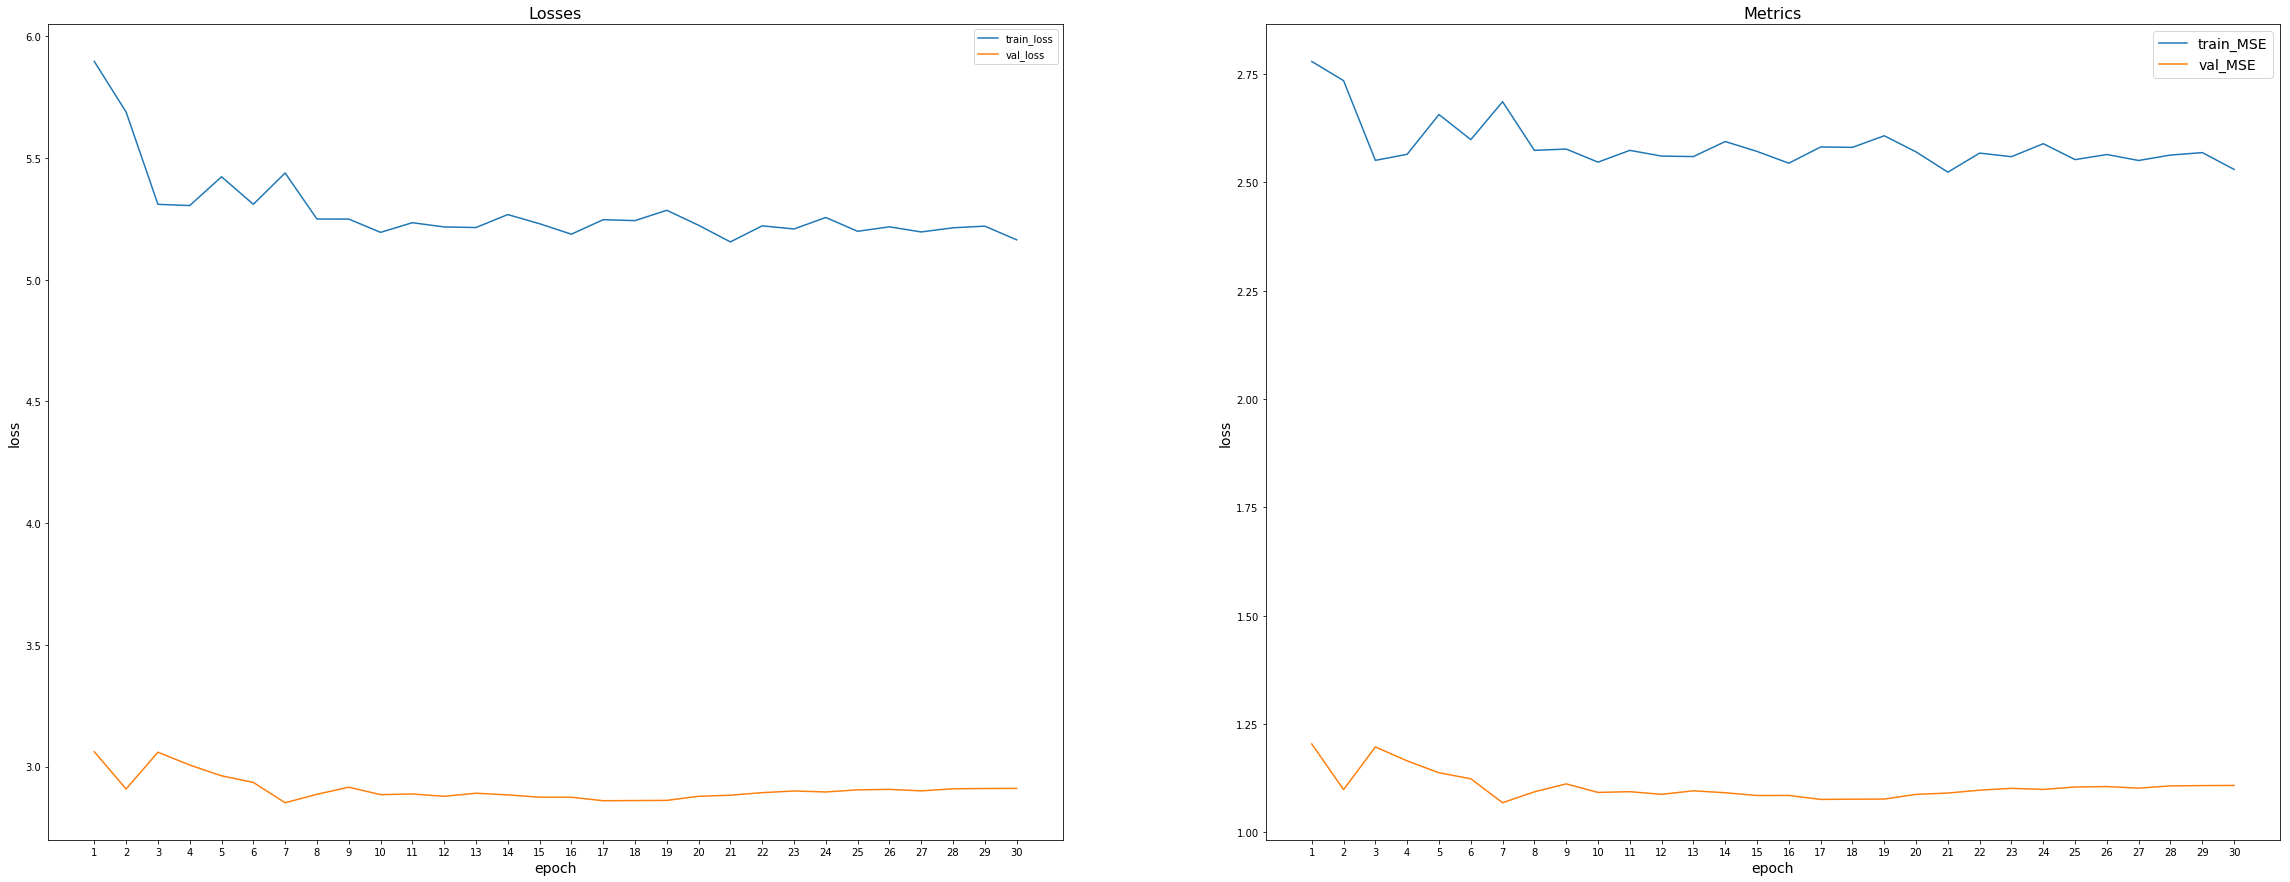

In [131]:
plot_history(history=history)

# 2) Output_size сеток с одномерным аутпутом (предполагаем независимость всех компонент силы)

Просто обучаю набор сеток на задачу регрессии, в качестве метрики для каждой сетки буду использовать MSE, а итоговая метрика - сумма MSE для каждой сетки

(Просто делаю массив из экземпляров сеток, optim-ов, loss-ов и потом циклом по ним делаю ровно тот же самый вызов history )

In [41]:
# Всем сеткам делаю абсолютно одинаковые гиперпараметры

models = [SingleNet(output_size=1) for _ in range(CFG.output_size)]

lr = 4e-3
betas=(0.9, 0.999)
weight_decay=0.1

optims = [optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay) for model in models]

step_size = 5
gamma = 0.1

exp_schedulers = [lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) for optimizer in optims]

criterion = nn.MSELoss()

Самое главное при обучении этих моделей - то что у model[ i ] - таргет - это число force[ i ]

In [42]:
def train_models():
    '''
    
    Возвращает словарь из history для всех моделей: {1: history, 2: history, ...}

    '''

    histories = defaultdict(list)

    # Надо менять немного цикл обучения, чтобы таргетом для i сетки была i-ая компонента вектора силы

    # for i in range(CFG.output_size):
    #     histories[str(i)] = train(
    #         train_loader=train_loader,
    #         val_loader=val_loader,
    #         model=model,
    #         optimizer=optimizer,
    #         scheduler=exp_scheduler,
    #         criterion=nn.MSELoss(),
    #         epochs=10
    #     )

# 3) GPR модель 
    - (потом можно сюда навалить и сетку в качестве ядра и вообще deep GP юзать, плюс еще feature extractor в виде сверток юзать сначала, если очень большая матрица, но сначала надо обычный сделать)

## 3.1) Не стохастический подход

https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html - как обучать модели в gpytorch

https://docs.gpytorch.ai/en/v1.3.1/examples/04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.html - как обучать GP по мини батчам, когда данных слишком много

У авторов $C_{mn}$ - это матрица ковариации по всему датасету, а $d_{mn}$ - некоторое введенное расстояние между матрицами, чтобы мы могли использовать экспоненциальное ядро, короче нам надо какое-то ядро, которое две матрицы, а не два числа принимает

- Весьма убедительно считать расстояние между матрицами просто как l2 метрику между точками в NxN мерном пространстве

Короче надо GPR сделать, у которого точки - матрицы и прогнозируется векторная величина, то есть для матрицы $x_*$ из инпута мы должны получать: $\mu_* = E[f(x_*)]$ - трехмерное мат ожидание для предсказания и $S$

In [43]:
import gpytorch

- В предположении что компоненты силы независимы, можно использовать Batch Independent Multioutput GP, предсказывая [fx, fy, fz]

- Если предсказывать k проекций на все V_i, то компоненты уже зависимые и надо это учитывать и использовать другую модель: MultitaskGPModel

лосс делаем -mll: минус логарифм правдоподобия: $-log[p(output Y | test X)]$

In [136]:
# train_X = torch.stack([elem[0] for elem in train_data])
# train_Y = torch.stack([elem[1] for elem in train_data])

# val_X = torch.stack([elem[0] for elem in val_data])
# val_Y = torch.stack([elem[1] for elem in val_data])

fl = flattener()
train_X = fl(torch.stack([elem[0] for elem in train_data]))
train_Y = torch.stack([elem[1] for elem in train_data])

val_X = fl(torch.stack([elem[0] for elem in val_data]))
val_Y = torch.stack([elem[1] for elem in val_data])

val_Y_3D = torch.stack([elem[3] for elem in val_data])
val_Y_pinv_As = torch.stack([elem[2] for elem in val_data])

**Про свертки и когда они ожидаемо будут и не будут работать:**

    - если мы используем обычный GP, то мы обязаны каждый шаг обучаться на всем train_X - так алгоритм работает, поэтому и сверточная сеть так же должна будет обучаться, по-сути с батч_сайз = дата_сайз, но оно так вычислительно неподъемно или просто не успеет за такое маленькое количество шагов обучиться

    - Поэтому стоит использовать алгоритм Stochastic Variational GP Regression, который подразумевает совместимость с torch.DataLoader, когда данных будет очень много, там используется стохастический алгоритм, позволяющий на батче обновлять параметры

In [45]:
class IndependentOutputsMultitaskGPModel(gpytorch.models.ExactGP):
    '''

    Class for multi output GPregression with independent components of output,
    formally we are training output_size GP models

    feature_extractor: torch network that consists only of convolutions (fully convolutional net)

    '''
    def __init__(self, train_x, train_y, likelihood, output_size=CFG.K, feature_extractor=None):
        super().__init__(train_x, train_y, likelihood)

        self.output_size = output_size

        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([output_size]))     # batch_shape позволяет нам для каждой модели отдельные параметры сделать
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([output_size])),
        )

        self.feature_extractor = flattener()
        if feature_extractor:
            self.feature_extractor = feature_extractor

        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

    def forward(self, x):

        convoluted_n_flattened_x = self.feature_extractor(x)   # flattening
        convoluted_n_flattened_x = self.scale_to_bounds(convoluted_n_flattened_x)

        mean_x = self.mean_module(convoluted_n_flattened_x)
        covar_x = self.covar_module(convoluted_n_flattened_x)

        # print(f'Сайз выпрямленного:  {convoluted_n_flattened_x.size()} \n Сам выпрямленный: {convoluted_n_flattened_x}')

        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

In [46]:
class MinusLogLikelihoodLoss:
    '''

    Object for computing NLLLoss

    '''
    def __init__(self, likelihood, model):
        self.mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    def __call__(self, model_output, true_target):
        '''

        model_output: what model(train_x) returns, i.e. distribution object, mll uses likelihood by itself

        returns -mll(output, target)

        '''
        return -self.mll(model_output, true_target)

In [47]:
class GPRMSELoss:
    '''
    
    object for calculation of MSE loss

    '''
    def __init__(self, likelihood):
        self.vanilla_MSE = MultuOutputMSELoss()
        self.likelihood = likelihood    # самописанные объекты изменяемые, поэтому этот имеет тот же id, что и глобальный likelihood

    def __call__(self, model_output, true_target):
        '''

        model_output: what model(train_x) returns, i.e. distribution object

        '''
        print(id(self.likelihood))
        mean_of_output = self.likelihood(model_output).mean

        return self.vanilla_MSE(mean_of_output, true_target)

In [48]:
def GP_train(likelihood, model, optimizer, loss_obj, training_iterations: int, train_X, train_Y, print_step=1, scheduler=None):
    '''

    loss_obj should be an object of a class, which has __call__ method

    to have a clear perspective: on a stochastic network training I used around 2500 iterations

    returns history of MSE and loss

    '''
    model.train()
    likelihood.train()

    history = defaultdict(list)

    # scaler = amp.GradScaler()
    
    # Здесь нам не надо running_loss и running_MSE, потому что подаем сразу весь датасета в типе non-stochastic GP

    # Здесь реально обучаются параметры GPR, поскольку некоторая параметрическая часть у GPR все-таки присутствует
    for i in range(training_iterations):
        optimizer.zero_grad()

        output = model(train_X)

        loss = loss_obj(output, train_Y)
        loss.backward()

        predictions = likelihood(model(train_X))
        mean = predictions.mean
        lower, upper = predictions.confidence_region()

        # train_MSE = F.mse_loss(input=mean, target=train_Y, reduction='mean').item()   оно неправильно вычисляется, потому что в режиме train, мы mean получаем не для распределения у предсказаний, а тот который выучиили по трейну,
        # Короче говоря в режиме train мы не \mu* для объектов при предсказания получаем, а \mu, которое получаем из трейн датасета

        if i % print_step == 0:
            print(f'Iter: {i + 1}, train_MSE = TODO, train_loss = {loss}')

        optimizer.step()

        # history['MSE'].append(train_MSE)
        history['loss'].append(loss.item())

        if scheduler:
            # Так как здесь обучение не по мини-батчам, то каждую итерацию обновление
            scheduler.step()

    return history

Можно еще в процессе обучения параметров периодически смотреть на качество на валидационной выборке

In [146]:
def GP_eval(likelihood, model, optimizer, loss_obj, val_X, val_Y, val_Y_pinv_As, val_Y_3D):
    '''
    
    One go dataset evaluation function

    '''
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        output = model(val_X)
        # loss = loss_obj(output, val_Y)

    predictions = likelihood(model(val_X))

    mean = predictions.mean
    lower, upper = predictions.confidence_region()

    mean_3D = torch.bmm(val_Y_pinv_As, torch.unsqueeze(mean.to(torch.float), 2)).to(torch.device("cpu"))    # используются для вычисления MSE метрики уже на 3D векторах силы
    mean_3D = torch.squeeze(mean_3D, -1)

    val_MSE = F.mse_loss(input=mean, target=val_Y, reduction='sum').item() / mean.size(0)
    val_MSE_for_3D = F.mse_loss(input=mean_3D, target=val_Y_3D, reduction='sum').item() / mean_3D.size(0)

    print(f'val_MSE = {val_MSE}, val_MSE_for_3D = {val_MSE_for_3D}')

    return mean, mean_3D

In [147]:
class FeatureExtractor(nn.Module):
    '''

    Класс одиночной нейронной сети

    '''
    def __init__(self, extracted_size=CFG.K * CFG.K):
        super().__init__()

        # self.FC = nn.Sequential(
        #     nn.Linear(CFG.K * CFG.K, 1024),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(1024),

        #     nn.Linear(1024, 512),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(512),
        #     nn.Linear(512, 256),

        #     nn.Linear(256, 128),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(128),
        #     nn.Linear(128, extracted_size)
        # )

        self.FC = nn.Sequential(
            nn.Linear(CFG.K * CFG.K, 128),
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.BatchNorm1d(128),
            nn.Linear(128, extracted_size),
        )

        # self.FC = nn.Linear(flattened_size, output_size)

    def forward(self, x):

        x = self.FC(x)

        return x

In [142]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=CFG.output_size)
feat_extractor = FeatureExtractor(extracted_size=32)

model = IndependentOutputsMultitaskGPModel(
    train_X,
    train_Y,
    likelihood,
    # feature_extractor=feat_extractor
    )

if likelihood.num_tasks != model.output_size:
    raise Exception('Different output dimensions for model and likelihood')

optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0)

NLL_loss = MinusLogLikelihoodLoss(likelihood=likelihood, model=model)
MSE_loss = GPRMSELoss(likelihood=likelihood)

exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

**Одно и то же значение для mean выводится в состоянии model.train(), потому что мы выбрали ConstMean и это типо и есть наше среднее, которое мы вычисляем по трейновому датасету**

In [143]:
train_history = GP_train(
    likelihood=likelihood,
    model=model,
    optimizer=optimizer,
    scheduler=None,
    
    loss_obj=NLL_loss,

    training_iterations=35,

    train_X=train_X,
    train_Y=train_Y,

    print_step=5
)

Iter: 1, train_MSE = TODO, train_loss = 1.592382550239563
Iter: 6, train_MSE = TODO, train_loss = 1.358294129371643
Iter: 11, train_MSE = TODO, train_loss = 1.0678733587265015
Iter: 16, train_MSE = TODO, train_loss = 0.7598523497581482
Iter: 21, train_MSE = TODO, train_loss = 0.5129071474075317
Iter: 26, train_MSE = TODO, train_loss = 0.28225454688072205
Iter: 31, train_MSE = TODO, train_loss = 0.049493495374917984


одинаковые аутпуты в eval будут, если у нас очень резко сетка становится широкой из низкоразмерных данных, если мы используем feature_extractor, то есть та же проблема, что была с сетками просто

In [144]:
mean, mean_3D = GP_eval(

    likelihood=likelihood,
    model=model,

    optimizer=optimizer,
    loss_obj=NLL_loss,

    val_X=val_X,
    val_Y=val_Y,

    val_Y_pinv_As=val_Y_pinv_As,
    val_Y_3D=val_Y_3D
)

val_MSE = 0.00193373979488237, val_MSE_for_3D = 0.00019534723079706086


In [63]:
val_Y_3D[0]

tensor([ 0.1196, -0.1886,  0.4450])

## 3.2) Stochastic Variational GP Regression (обучение GPR по мини батчам):

---

# Пока мои выводы / результаты: 

- Про сетки:
    - Поскольку в датасете огромное количество сил очень маленькие - модель не в состоянии научиться определять болшьие силы, надо какой-то кастомный лосс придумывать, учитывающий это

    - Пока по какой-то причине сетка просто выдает одинаковый аутпут на весь батч на большом количестве частиц (и со свертками и без, и при большом и при маленьком K)

    - Для 2 частиц с K = 2 на одной сетке получилось val_MSE = 0.75

    - Для 50 частиц с K = 25 вообще ничего не вышло, с K = 5 пока тоже

Поэтому я пока отложу идею с 3 сетками и попробую покрутить GPR

- Про GP:
    - на 50 частицах пока оно не учится...

    - на 2 частицах результат получше, чем у сетки, но что-то мне подсказывает, что MSE довольно плохая метрика в нашей ситуации

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler, scaler=None):
    '''

    Функция обучения по всем батчам 1 раз (1 эпоха)

    scaler: gradient scaler from torch.amp, попозже добавлю обучение с ним

    '''
    model.train()
    scaler = amp.GradScaler()

    running_loss = 0.0
    running_MSE = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)

        with amp.autocast(enabled=True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)

        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        running_MSE += F.mse_loss(input=outputs, target=labels, reduction='sum').item()
        processed_data += inputs.size(0)

    scheduler.step()
              
    train_loss = running_loss / processed_data
    train_MSE = running_MSE / processed_data
    
    return train_loss, train_MSE